## 1. Data Exploration and Preprocessing 
This step involves loading and analyzing the dataset, handling missing values, and performing necessary feature transformations.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

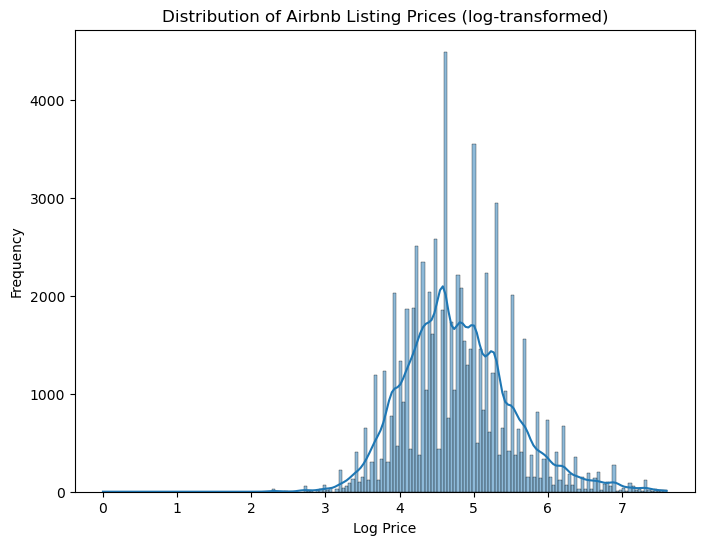

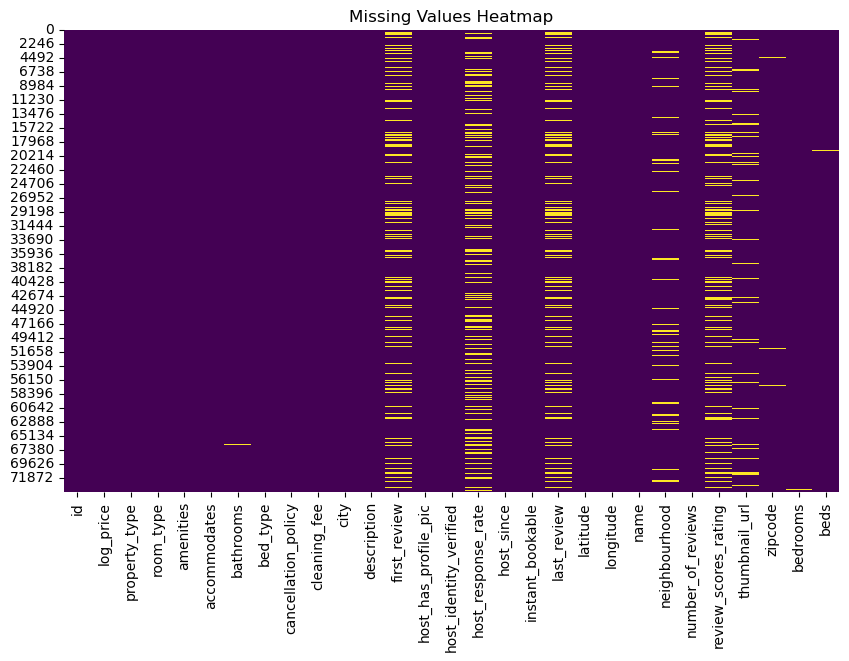

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('airbnb.csv')

# Display basic dataset information
print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print(f"Missing Values:\n{missing_values}")

# Visualize the distribution of the target variable (log_price)
plt.figure(figsize=(8, 6))
sns.histplot(data['log_price'], kde=True)
plt.title('Distribution of Airbnb Listing Prices (log-transformed)')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

# Visualize missing values (optional)
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Handle missing values by using SimpleImputer (later in the code for each feature type)


## Explanation:
Missing Values: We checked for missing values to understand how much data is missing.

Visualizations: A histogram is created for the target variable (log_price), and a heatmap is shown to visualize missing data.

Data Splitting: The dataset is split into training and testing sets for model evaluation.

## 2. Model Development 
This step focuses on building the regression model and optimizing it using RandomizedSearchCV for hyperparameter tuning.

In [10]:
# Separate features and target variable
X = data.drop(columns=['log_price'])
y = data['log_price']

# Use a smaller subset of the data for quicker testing
X_train_subset, _, y_train_subset, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline: Impute missing values and scale features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Impute missing values and apply one-hot encoding
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines into a column transformer
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Define the model pipeline with preprocessing and RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, max_samples=0.5, warm_start=True))  # Warm start and max_samples
])

# Define hyperparameter grid for RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'regressor__n_estimators': randint(50, 100),  # Limit n_estimators between 50 and 100
    'regressor__max_depth': [10, 20, 30],  # Limiting max depth
    'regressor__min_samples_split': randint(2, 5),
    'regressor__min_samples_leaf': randint(1, 5),
}

# Perform RandomizedSearchCV with 3-fold cross-validation and parallelization
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=5,  # Reduce the number of iterations
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all CPU cores for parallelization
    verbose=2,  # Show progress
    random_state=42
)

# Fit the RandomizedSearchCV
random_search_rf.fit(X_train_subset, y_train_subset)

# Best model after tuning
best_rf_model = random_search_rf.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


## Explanation:
Data Preparation: We define numeric and categorical features, creating separate pipelines for them (imputation and scaling for numeric data, imputation and one-hot encoding for categorical data).

Random Forest Model: The RandomForestRegressor is used to predict Airbnb prices, with hyperparameters optimized using RandomizedSearchCV.

## 3. Model Evaluation 
Once the model is built, we evaluate its performance using metrics like Mean Squared Error (MSE) and R².

Train Mean Squared Error: 0.1632285913996811
Test Mean Squared Error: 0.17093782512987163
Train R^2: 0.6829684433994714
Test R^2: 0.6672586965033624


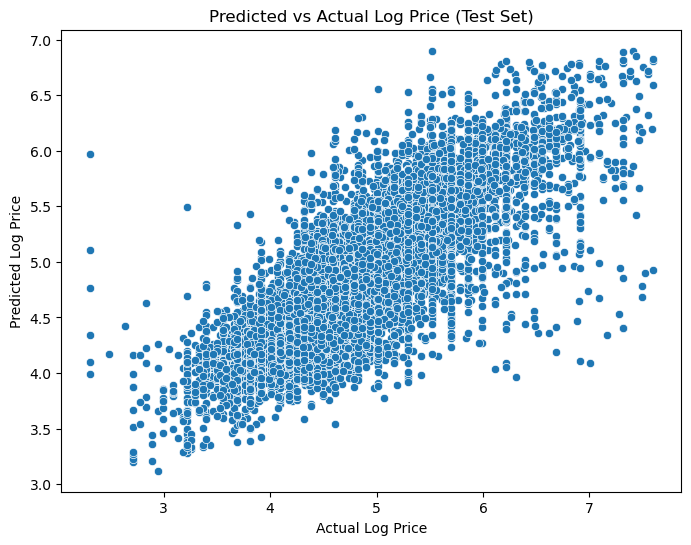

In [20]:
# Model evaluation on train and test data
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, r2_score

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print(f"Train Mean Squared Error: {train_mse}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

# Visualization of model performance: Predicted vs Actual for Test Set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.title('Predicted vs Actual Log Price (Test Set)')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.show()


## Model Evaluation Metrics:
Train Mean Squared Error (MSE): 0.1632

This indicates the average squared difference between the predicted values and the actual values on the training dataset. Lower MSE suggests the model fits the training data well.
Test Mean Squared Error (MSE): 0.1709

Similar to the train MSE, this metric indicates how well the model generalizes to the unseen test data. Since the test MSE is close to the train MSE, it suggests the model is not overfitting.
Train R²: 0.6830

This indicates that approximately 68.3% of the variance in the target variable (log_price) can be explained by the model on the training dataset. Higher R² suggests that the model captures a significant portion of the data’s variance.
Test R²: 0.6673

This indicates that approximately 66.7% of the variance in the target variable is explained by the model on the test dataset. The fact that the test R² is close to the train R² reinforces the idea that the model generalizes well.
Visualizations:
Predicted vs Actual: If you didn't already, it's helpful to visualize the predicted values vs. the actual values on the test set. This can help to better understand how well the model is performing and where it might be making errors.

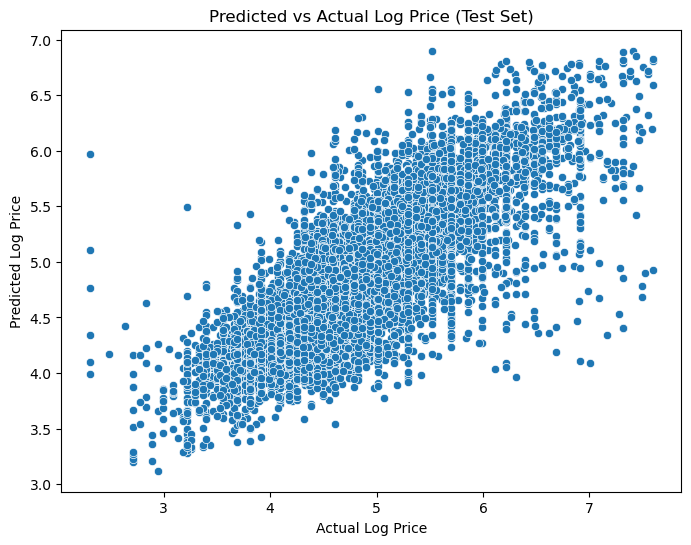

In [23]:
# Visualization of model performance: Predicted vs Actual for Test Set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.title('Predicted vs Actual Log Price (Test Set)')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.show()


## Further Improvements:
Feature Importance: To provide insights into which features are most important in predicting Airbnb prices, you can plot the feature importance of the Random Forest model.

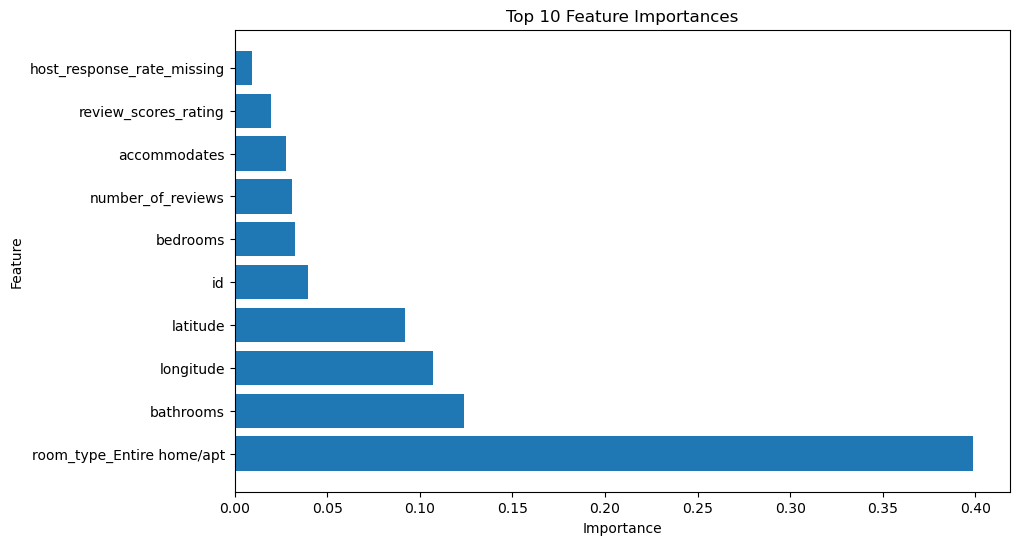

In [27]:
# Plotting feature importance
import numpy as np

# Get feature importances from the best model
feature_importances = best_rf_model.named_steps['regressor'].feature_importances_

# Get feature names
feature_names = numeric_features.tolist() + list(best_rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importances[sorted_idx[:10]], align='center')
plt.yticks(range(10), np.array(feature_names)[sorted_idx[:10]])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Summary:
Your model's performance metrics indicate a strong fit to the data with good generalization to the test set.
Visualizations like the Predicted vs Actual plot can further clarify how well the model is performing.
Additional steps like plotting feature importance can help identify key factors influencing the prices, which can be useful for stakeholder insights.